In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m')

In [3]:
ice_cream_heater_df = pd.read_csv('ice_cream_vs_heater.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [4]:
ice_cream_heater_df

,heater,ice cream
Month,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21
...,...,...
2020-02-01,34,45
2020-03-01,25,44
2020-04-01,25,53


In [5]:
ice_cream_heater_df = ice_cream_heater_df.asfreq(pd.infer_freq(ice_cream_heater_df.index))

infer_freq Versucht, eine Zeichenfolge zurückzugeben, die eine von infer_freq generierte Häufigkeitsschätzung darstellt. Gibt None zurück, wenn die Häufigkeit nicht automatisch erkannt werden kann.

In [6]:
print(ice_cream_heater_df.index.min())
print(ice_cream_heater_df.index.max())

2004-01-01 00:00:00
2020-06-01 00:00:00


Daten beziehen sich auf interesse am Suchbegriff Ice Cream vs Interesse an dem Suchbegriff Heitzung im laufe der zeit in den USA von Google trends... 

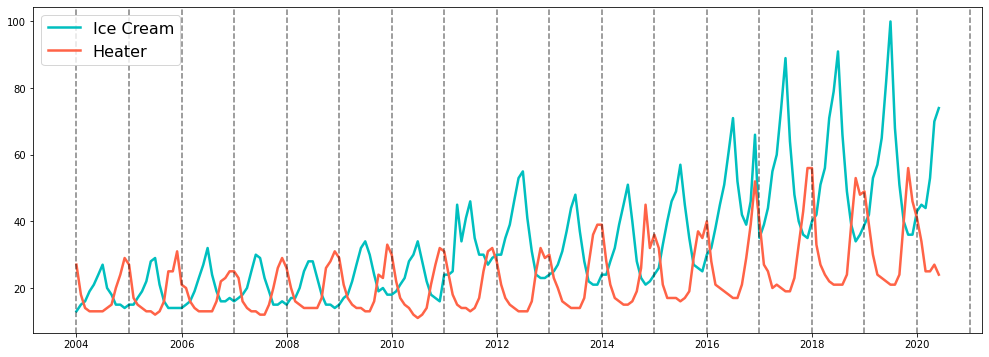

In [7]:
plt.figure(figsize= (17,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'],color=('c'),linewidth=2.5)
heater, = plt.plot(ice_cream_heater_df['heater'], color='tomato',linewidth=2.5)

for year in range(2004, 2022):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

Wir sehen das das interesse an dem Suchbegriff Eis in den Sommermonaten seine höhepunkte hat und der suchbrgriff Heitzung in den wintermonaten. Außerdem sehen wir das über die jahre immer mehr solcher suchanfragen aufkommen. 

**Normalisieren der daten**

In [8]:
avgs = ice_cream_heater_df.mean()
devs = ice_cream_heater_df.std()

In [9]:
#wir errechnen für Ice und heater (X) in einer for schleife ( x - avg) /  dev
for col in ice_cream_heater_df.columns:
    ice_cream_heater_df[col] = (ice_cream_heater_df[col] - avgs.loc[col]) / devs.loc[col]

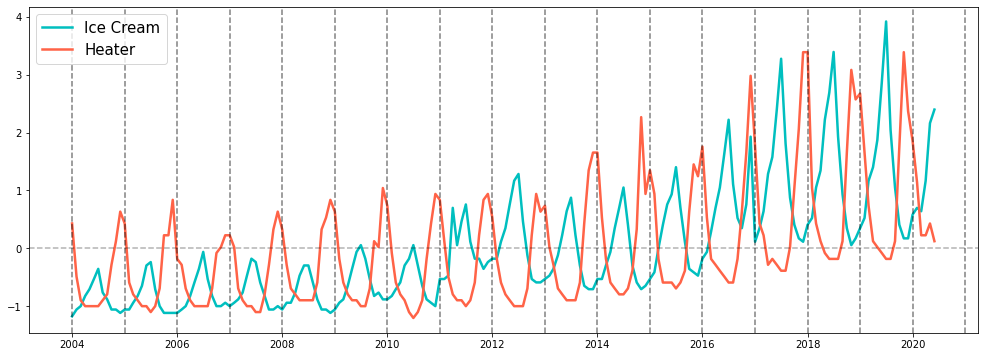

In [10]:
plt.figure(figsize=(17,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'],color='c',linewidth=2.5)
heater, = plt.plot(ice_cream_heater_df['heater'],color='tomato',linewidth=2.5)

for year in range(2004, 2022):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

plt.legend(['Ice Cream', 'Heater'], fontsize=15);

**Nehmen wir den ersten Unterschied, um den Trend zu entfernen**

Ein weg ist es die erste differenz zu nehmen um die Stationarität zu entfernen Kapitel 2 (Da es eine dauerhaft steigente nachfrage bei heater suchanfrage gibt)  https://www.uni-goettingen.de/de/document/download/bced8d2cf092e3487839c365955c85f2.pdf/ZRSkript_Teil2_Okt09.pdf

In [11]:
ice_cream_heater_df = ice_cream_heater_df.diff().dropna()# diff erste differenz der daten 
#dropna da es vor dem ersten Wert keinen weiteren Wert gibt da wir kein Nan wollen drop 

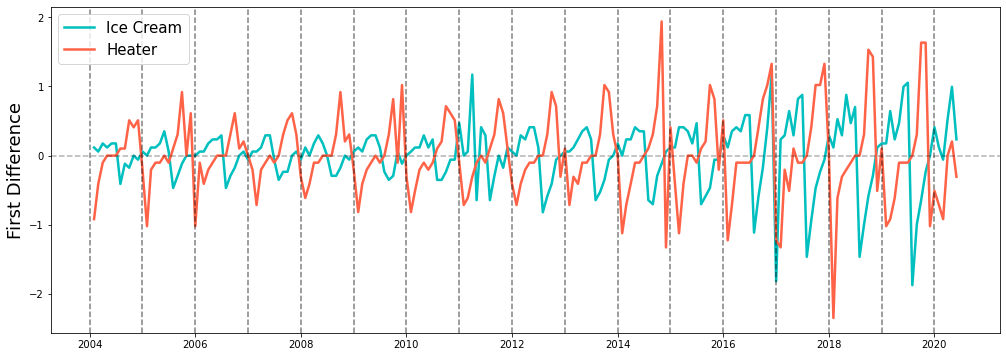

In [12]:
plt.figure(figsize=(17,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'],color='c',linewidth=2.5)
heater, = plt.plot(ice_cream_heater_df['heater'],color='tomato',linewidth=2.5)

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=15);

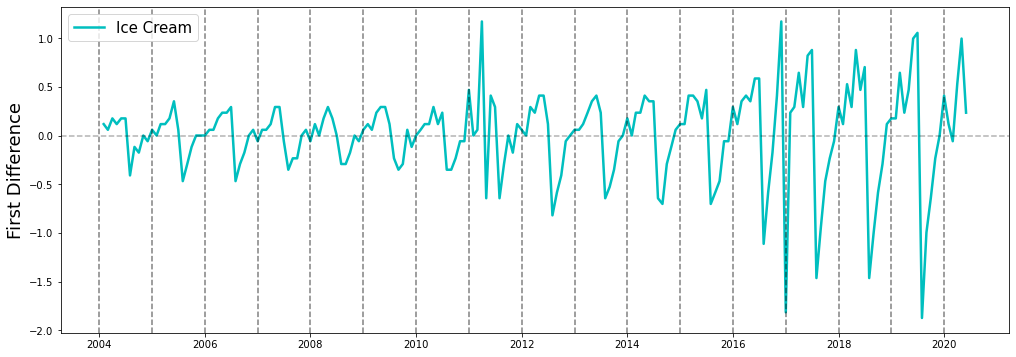

In [13]:
plt.figure(figsize=(17,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'],color='c',linewidth=2.5)

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=15);

Jetzt haben wir das problem mit der steigung gelöste wir haben aber weiterhin eine steigende volatilität. Das ist das problem.(Volatilität misst die Intensität der Schwankungen) Die volatilität muss konstant sein also entfernen wir die Schwankungen.

**Entfernen wir die zunehmende Volatilität**

In [14]:
#wir gruppieren nach jahren und nehmen die standardabweichung
annual_volatility = ice_cream_heater_df.groupby(ice_cream_heater_df.index.year).std()
annual_volatility

,heater,ice cream
Month,,
2004,0.415481,0.184201
2005,0.474527,0.214837
2006,0.400148,0.227698
2007,0.359839,0.198947
2008,0.396182,0.183239
2009,0.499810,0.221038
2010,0.459566,0.211668
2011,0.443924,0.501018
2012,0.471104,0.389711


Wir sehen das die zahlen steigen. 
Mit Hilfe des lambda-Operators können anonyme Funktionen, d.h. Funktionen ohne Namen erzeugt werden. Sie haben eine beliebe Anzahl von Parametern, führen einen Ausdruck aus und liefern den Wert dieses Ausdrucks als Rückgabewert zurück.
Wir können die integrierte Python-Funktion map() verwenden, um für jedes Element in einer Iterablen (wie einer Liste oder einem Wörterbuch) eine Funktion anzuwenden und einen neuen Iterator zum Abrufen der Ergebnisse zurückgeben.

In [15]:
#formt eine serie die die gleiche länge hat wie unsere daten 
ice_cream_heater_df['ice_cream_annual_vol'] = ice_cream_heater_df.index.map(lambda d: annual_volatility.loc[d.year, 'ice cream'])
ice_cream_heater_df['heater_annual_vol'] = ice_cream_heater_df.index.map(lambda d: annual_volatility.loc[d.year, 'heater'])
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol
Month,,,,
2004-02-01,-0.918789,0.117140,0.184201,0.415481
2004-03-01,-0.408351,0.058570,0.184201,0.415481
2004-04-01,-0.102088,0.175710,0.184201,0.415481
2004-05-01,0.000000,0.117140,0.184201,0.415481
2004-06-01,0.000000,0.175710,0.184201,0.415481
...,...,...,...,...
2020-02-01,-0.714614,0.117140,0.369810,0.426657
2020-03-01,-0.918789,-0.058570,0.369810,0.426657
2020-04-01,0.000000,0.527129,0.369810,0.426657


In [16]:
ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] / ice_cream_heater_df['ice_cream_annual_vol']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] / ice_cream_heater_df['heater_annual_vol']

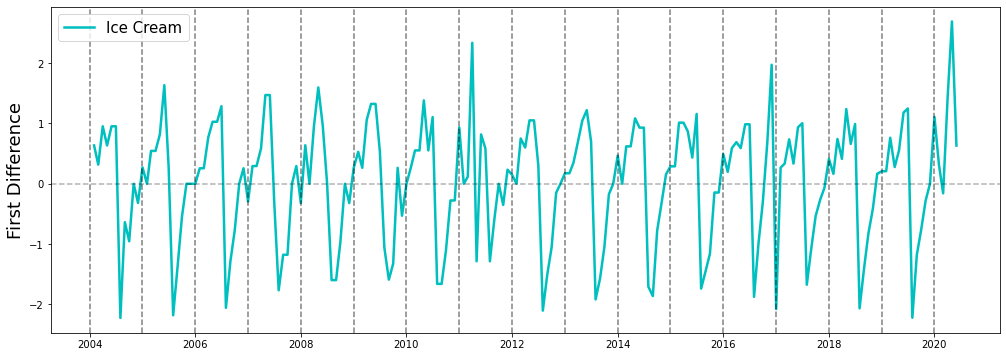

In [17]:
plt.figure(figsize=(17,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'],color='c',linewidth=2.5)

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=15);

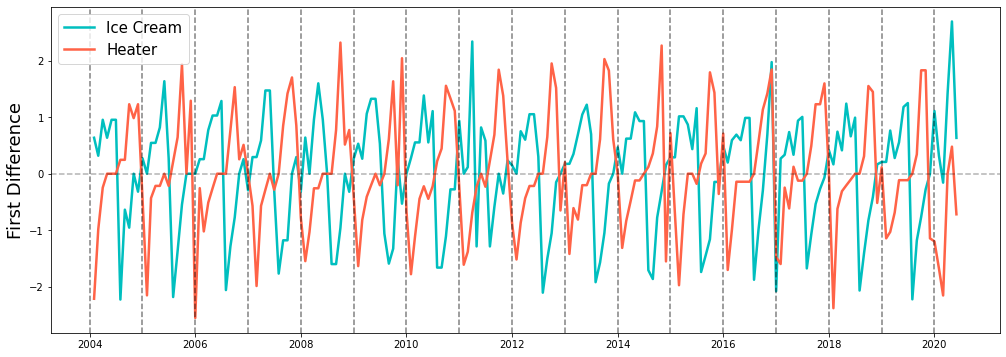

In [18]:
plt.figure(figsize=(17,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'],color='c',linewidth=2.5)
heater, = plt.plot(ice_cream_heater_df['heater'], color='tomato',linewidth=2.5)

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=15)

Es sieht so aus als hatten wir jetzt eine konstante varianz über die zeit wir haben die steigende schwankung und die steigung über die zeit behoben.   
Wie sehen weiterhin das saisonale muster diese müssen wir auch beheben. Wir werden es ähnlich machen wie zuvor indem wir den Moant verwenden anstatt dem Jahr. 

**Saisonalität entfernen**

In [19]:
month_avgs = ice_cream_heater_df.groupby(ice_cream_heater_df.index.month).mean()
print(month_avgs)

         heater  ice cream  ice_cream_annual_vol  heater_annual_vol
Month                                                              
1     -0.428360   0.130345              0.415976           0.580717
2     -1.483129   0.250194              0.402342           0.570997
3     -1.063595   0.433016              0.402342           0.570997
4     -0.442926   0.838085              0.402342           0.570997
5     -0.121663   0.967273              0.402342           0.570997
6     -0.128425   0.987311              0.402342           0.570997
7     -0.107093   0.735052              0.404376           0.580018
8      0.075720  -1.821285              0.404376           0.580018
9      0.544638  -1.307661              0.404376           0.580018
10     1.613170  -0.830889              0.404376           0.580018
11     1.183118  -0.088136              0.404376           0.580018
12     0.491641   0.088998              0.404376           0.580018


In [20]:
#h_month_avgs = h_series.index.map(lambda d: h_month_avgs.loc[d.month]) 
ice_cream_heater_df['ice_cream_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'ice cream'])
ice_cream_heater_df['heater_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'heater'])
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-2.211387,0.635934,0.184201,0.415481,0.250194,-1.483129
2004-03-01,-0.982838,0.317967,0.184201,0.415481,0.433016,-1.063595
2004-04-01,-0.245710,0.953901,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.000000,0.635934,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.000000,0.953901,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-1.674916,0.316756,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-2.153463,-0.158378,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.000000,1.425403,0.369810,0.426657,0.838085,-0.442926


In [21]:
ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] - ice_cream_heater_df['ice_cream_month_avg']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] - ice_cream_heater_df['heater_month_avg']
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-0.728257,0.385740,0.184201,0.415481,0.250194,-1.483129
2004-03-01,0.080757,-0.115049,0.184201,0.415481,0.433016,-1.063595
2004-04-01,0.197217,0.115816,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.121663,-0.331339,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.128425,-0.033411,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-0.191787,0.066562,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-1.089868,-0.591394,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.442926,0.587318,0.369810,0.426657,0.838085,-0.442926


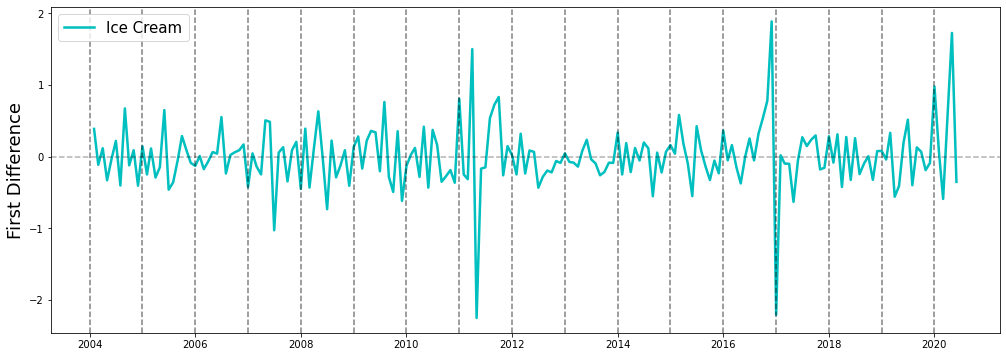

In [22]:
plt.figure(figsize=(17,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'],color='c',linewidth=2.5)

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=15)

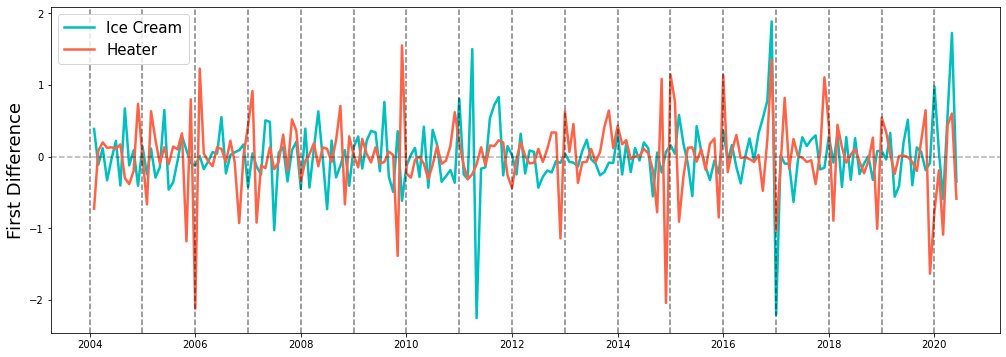

In [23]:
plt.figure(figsize=(17,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'],color='c',linewidth=2.5)
heater, = plt.plot(ice_cream_heater_df['heater'], color='tomato',linewidth=2.5)

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=15)

Nun haben wir die daten vorbereitet. Die Stationarität ist deutlich sichtbarer als in den grafen zuvor. jetzt geht es an die tatsächliche Modelisierung.

welchen verzögerung sollten wir für Treffer einer Zeitreihe verwenden.

Regressionsanalysen haben das Ziel, Beziehungen zwischen einer abhängigen und einer oder mehreren unabhängigen Variablen zu modellieren und somit zur forhersage beitragen. (Regression basiert auf der Korrelation) Die AR ist eine spezielle form der Regression welche die vorhersage aufgrund von früheren werten nutzt um vorherzusagenden auf deren werten zu treffen.  

**AR(2) PFCF Partielle Autokorrelationsfunktion** (hier gucken wir nur nach den dirketen effekten und lassen die indirekten zusammenhängen die bei AR(1) ACF( Autokorrelationsfunktion) mit einbezogen werden weck um den direkten zusammenhand von einem.   
anfangswert auf unsere zukünftige prognose zu sehen)  

AR Autoregressive Modelle https://otexts.com/fpp2/AR.html

Heater


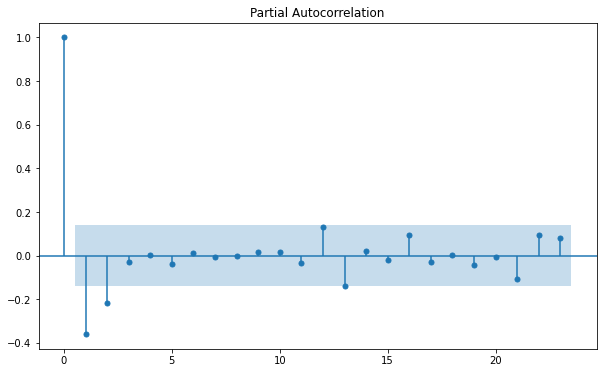

In [24]:
plt.rc("figure", figsize=(10,6))
plot_pacf(ice_cream_heater_df['heater']);
print('Heater')

Wir verwenden 2 Zeitabstände da en nach dem 2 auf 0 geht. Betrachten wir also ein AR(2).

Ice cream


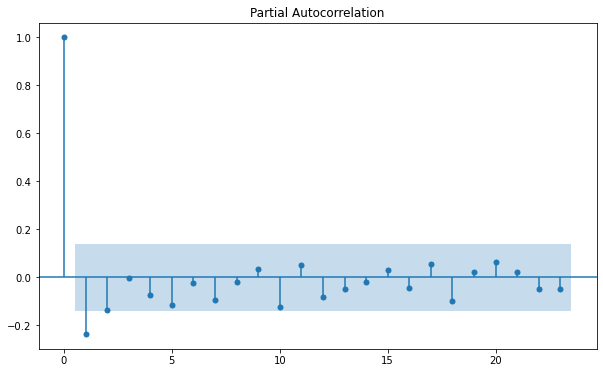

In [25]:
plt.rc("figure", figsize=(10,6))
plot_pacf(ice_cream_heater_df['ice cream']);
print('Ice cream')

**Zusammenhang zwischen "Heizung" und verzögertem "Eis"**

In [28]:
#wir betrachenten hier alle Zeitabschnitte zwischen 1 un 13 und dann gucken wir was ist die Korrelation.

for lag in range(1, 14):
    heater_series = ice_cream_heater_df['heater'].iloc[lag:]
    lagged_ice_cream_series = ice_cream_heater_df['ice cream'].iloc[:-lag]
    print('Monatsabstand: %s'%lag)
    print(pearsonr(heater_series, lagged_ice_cream_series))# pearsonr korrelation
    print('------')

Monatsabstand: 1
(-0.0315445074259157, 0.660728499174997)
------
Monatsabstand: 2
(-0.09872703210944636, 0.1697084190508982)
------
Monatsabstand: 3
(-0.0017838553789235254, 0.9803056762962026)
------
Monatsabstand: 4
(0.06023971859825538, 0.4052979832528944)
------
Monatsabstand: 5
(-0.05403486448015028, 0.45664426275062703)
------
Monatsabstand: 6
(0.06461183026553834, 0.37453000434455314)
------
Monatsabstand: 7
(-0.04949334618415869, 0.49768766857621993)
------
Monatsabstand: 8
(0.07890837135977347, 0.2804548970433355)
------
Monatsabstand: 9
(-0.053235016996004275, 0.4681034202228288)
------
Monatsabstand: 10
(0.029536989060791174, 0.6882054906332707)
------
Monatsabstand: 11
(-0.05979536351522571, 0.41752174204858805)
------
Monatsabstand: 12
(-0.07513046035981785, 0.3094409252542959)
------
Monatsabstand: 13
(0.19808902198429754, 0.007029107082073339)
------


Wir wollen nur nach korrelationen gucken wo der p value(die Wahrscheinlichkeit) kleiner ist als 0,5. Monatsabstand: 13 ist 1 jahr minus 1 monat zurück. Sagt uns das vielleicht der 13 monatsabstand signifikant ist wenn man auf die heitzungs zeitfolge vorhersagen will basierend auf den monadsabstand von Eis.

**Anpassen eines VAR-Modells**

In [35]:
#da wie 2 spalten haben betrachten wir diese als unsere beiden zeit serien 
ice_cream_heater_df = ice_cream_heater_df[['ice cream', 'heater']] 

In [31]:
model = VAR(ice_cream_heater_df)

In [32]:
model_fit = model.fit(maxlags=13)

In [33]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Nov, 2021
Time:                     18:57:44
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.92349
Nobs:                     184.000    HQIC:                  -2.48459
Log likelihood:          -204.405    FPE:                  0.0571123
AIC:                     -2.86700    Det(Omega_mle):       0.0434311
--------------------------------------------------------------------
Results for equation ice cream
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.016054         0.034105           -0.471           0.638
L1.ice cream         -0.287811         0.079633           -3.614           0.000
L1.heater            -0.121251         0.073673         

Da nicht gesagt wurde welche der beiden die variable ist die uns interresiert bahandelt er beide also heater und ice cream als die variablen die uns interresieren. Deswegen gibt es 2 resultate.
Die prob spalte ist unsere p value (die Wahrscheinlichkeit) spalte. 

Bei heater sind L1 (lag 1) und L2 (lag 2) und L13 (lag 13) die Monatsabstände die unter 0,5 sind und damit für uns relevant sind. 

Wenn wir jetzt in der spalte coefficient diese Lags auswählen kommen wir auf folgendes entgültiges Modell für heater.

**Unser endgültiges Modell ist also:**